### Tutorial
A simple tutorial for using the gravity simulator API. This file also serves as documentation.

### Import libraries
First, we import some libraries. If the path is wrong, please correct it manually.

In [1]:
import sys
from pathlib import Path

parent_path = str(Path.cwd().parent)
sys.path.append(parent_path)
print(f"Appended path: \"{parent_path}\"")

import numpy as np

from gravity_sim import GravitySimulator

grav_sim = GravitySimulator()
grav_sim.integration_mode = "c_lib"  # Default is "c_lib", but you can set it to "numpy"
print()
print(grav_sim.DEFAULT_SYSTEMS)
print(grav_sim.AVAILABLE_INTEGRATORS)

Appended path: "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator"

['circular_binary_orbit', 'eccentric_binary_orbit', '3d_helix', 'sun_earth_moon', 'figure-8', 'pyth-3-body', 'solar_system', 'solar_system_plus', 'custom']
['euler', 'euler_cromer', 'rk4', 'leapfrog', 'rkf45', 'dopri', 'dverk', 'rkf78', 'ias15', 'whfast']


### Load pre-defined system

In [2]:
system = grav_sim.create_system()
grav_sim.set_current_system(system)
system.load("solar_system")

### Adding new objects
Note that the default units are solar masses, AU and days

In [3]:
x = np.array([-8.092549658731499e-02, 2.558381434460076e00, -6.695836142398572e-02])
v = np.array(
    [
        -1.017876585480054e-02,
        -5.452367109338154e-04,
        1.255870551153315e-03,
    ]
)
m = 1.30268459e-10
system.add(x, v, m, object_name="New object 1")

system.add_keplerian(
    semi_major_axis=4.2,
    eccentricity=0.1,
    inclination=0.1,
    longitude_of_ascending_node=1.0,
    argument_of_periapsis=1.0,
    true_anomaly=1.0,
    m=1.5e-9,
    primary_object_name="Sun",
    object_name="New object 2",
)

system.center_of_mass_correction()

### Save system

In [4]:
system.save("Tutorial")

# You can also load a customized system stored in customized_systems.csv
# system.load("Tutorial")

System "Tutorial" saved to "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator/gravity_sim/customized_systems.csv"


### Plotting initial conditions

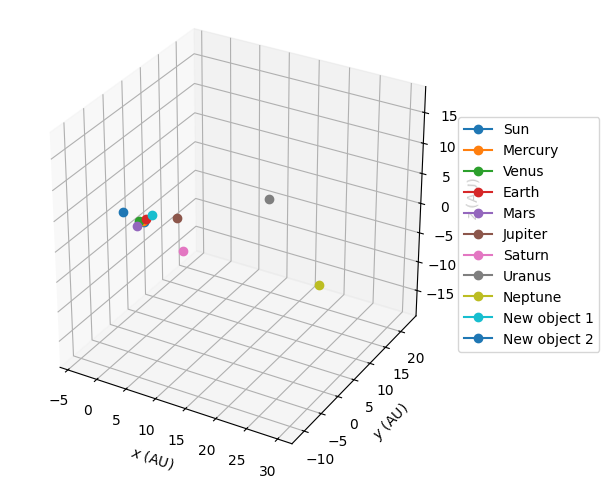

In [5]:
system.plot_3d_system(
    labels=system.objects_names,
    legend=True,
)

### Launching simulation

In [6]:
grav_sim.launch_simulation(
    integrator="leapfrog",
    tf=grav_sim.years_to_days(1000.0),
    dt=grav_sim.years_to_days(0.001),
    store_every_n=500,
    acceleration_method="pairwise",  # "pairwise" is the default value. Set it to "massless" if you have massless particles
)

Output()

Simulation information
Integration mode:  c_lib
System:  Tutorial
Integrator:  LeapFrog
tf: 365242.189 days
dt: 0.365242189 days
tolerance:  None
store_every_n:  500
acceleration_method:  pairwise
storing_method:  default
flush_results_path:  None
no_progress_bar:  False
no_print:  False
softening_length:  0.0
Simulating the system...


Run time: 0.417 s



In [7]:
print(f"Data size = {grav_sim.data_size}")

Data size = 2001


### Plotting trajectories

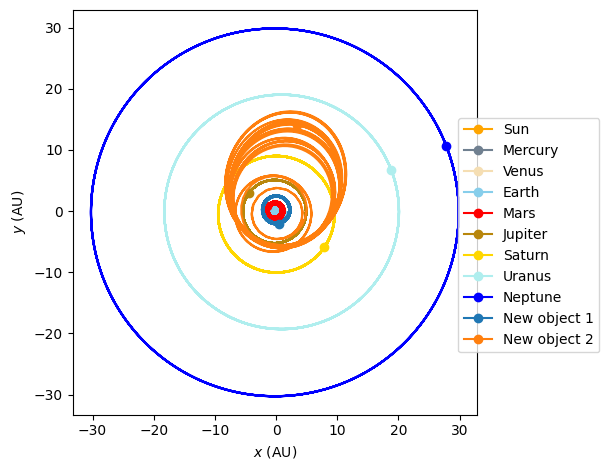

In [8]:
grav_sim.plot_2d_trajectory(
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=system.objects_names,
    legend=True,
)

### More plots

Output()

Computing energy...


Run time: 0.161 s



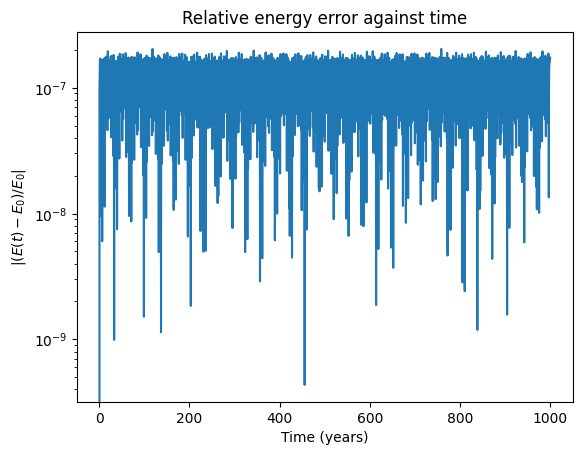

In [9]:
# grav_sim.compute_energy()
grav_sim.plot_rel_energy(
    sol_time=grav_sim.days_to_years(grav_sim.sol_time), xlabel="Time (years)"
)

Output()

Computing angular momentum...


Run time: 0.112 s



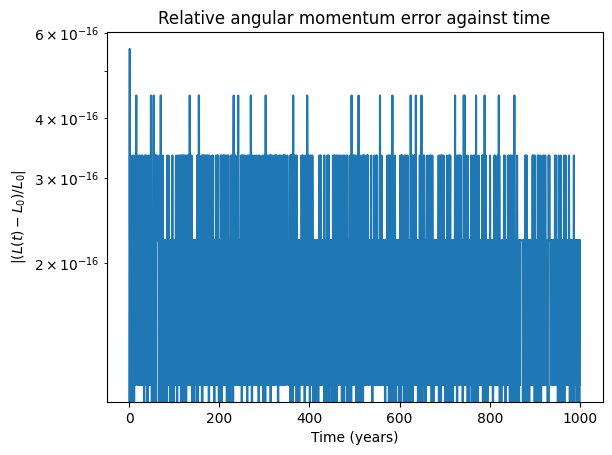

In [10]:
# grav_sim.compute_angular_momentum()
grav_sim.plot_rel_angular_momentum(
    sol_time=grav_sim.days_to_years(grav_sim.sol_time), xlabel="Time (years)"
)

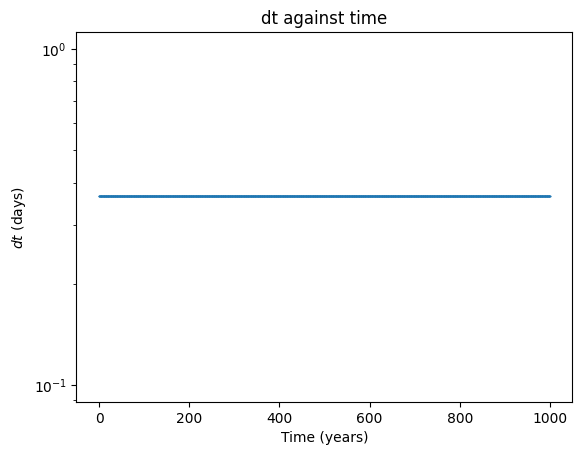

In [11]:
grav_sim.plot_dt(
    sol_time=grav_sim.days_to_years(grav_sim.sol_time), xlabel="Time (years)"
)

### Animations

In [12]:
grav_sim.animate_3d_traj_gif(
    is_maintain_fixed_dt=False,
    fps=30,
    dpi=200,
    plot_every_nth_point=5,
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=system.objects_names,
    legend=True,
    traj_len=50,
    file_name="tutorial.gif",
)

Output()

Saving the file...
Output completed! Please check "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator/gravity_sim/results/tutorial.gif"



### Save and reading results

In [13]:
grav_sim.save_results()

# grav_sim.load_results(file_path="Your_file_path.csv")

Output()

Computing energy...
Computing energy...


Output()

Run time: 0.108 s

Storing simulation results...


Storing completed. Please check "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator/gravity_sim/results/2024-09-23_23-37-32_result.csv"


### Splitting simulations into multiple sessions (Not available for WHFast)
After a simulation session, you can simply call `grav_sim.resume_simulation(simulation_time)` to launch a new session with the last saved state.
All the simulation parameters remains the same.
However, note that all the previous simulation history will be gone, so save them first before you resume the simulation.

*For WHFast, using `resume_simulation` would introduce error due to unknown bugs and is thus not recommended.

Output()

Simulating the system...


Run time: 0.638 s



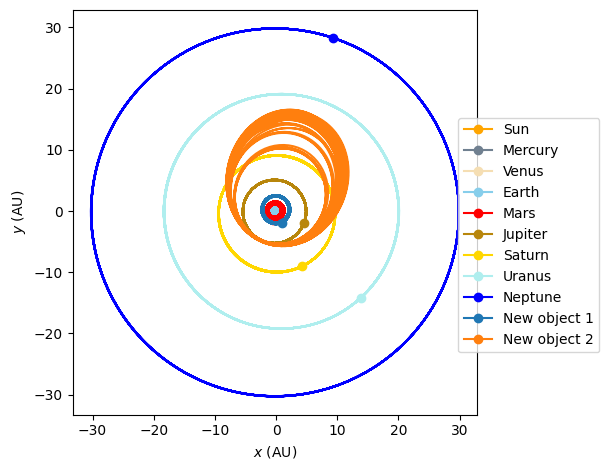

In [14]:
grav_sim.resume_simulation(tf=grav_sim.years_to_days(2000.0))

grav_sim.plot_2d_trajectory(
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=system.objects_names,
    legend=True,
)

### Adaptive step size integrators

When using adaptive step size integrators, we provide tolerance rather than $\text{d}t$ to control the step size.
| Adaptive step size integrators | Recommended tolerance* |
|:-----------|:-------------|
| Runge–Kutta–Fehlberg 4(5) | $10^{-8}$ to $10^{-14}$ |
| Dormand–Prince method (DOPRI) 5(4) | $10^{-8}$ to $10^{-14}$ |
| Verner's method (DVERK) 6(5) | $10^{-8}$ to $10^{-14}$ |
| Runge–Kutta–Fehlberg 7(8) | $10^{-4}$ to $10^{-8}$ |
| IAS15 | $10^{-9}$ |

*For reference only

Using pyth-3-body, a highly chaotic system, we can easily see the difference between adaptive step size integrators and fixed step size integrators.

For RK4, the largest $\text{d}t$ we can use for this system is 2e-8.

Output()

IAS15:
Simulation information
Integration mode:  c_lib
System:  pyth-3-body
Integrator:  IAS15
tf: 70.0 days
dt: None days
tolerance:  1e-09
store_every_n:  1
acceleration_method:  pairwise
storing_method:  default
flush_results_path:  None
no_progress_bar:  False
no_print:  False
softening_length:  0.0
Simulating the system...


Run time: 0.220 s



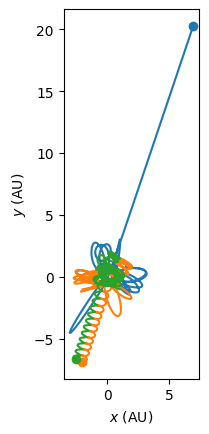

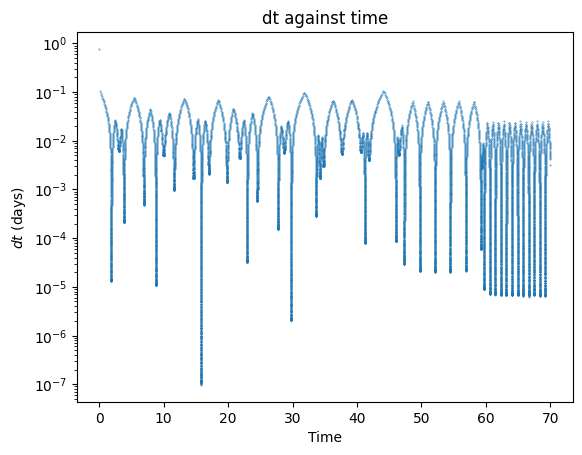

Output()

RK4:
Simulation information
Integration mode:  c_lib
System:  pyth-3-body
Integrator:  RK4
tf: 70.0 days
dt: 1e-05 days
tolerance:  None
store_every_n:  10000
acceleration_method:  pairwise
storing_method:  default
flush_results_path:  None
no_progress_bar:  False
no_print:  False
softening_length:  0.0
Simulating the system...


Run time: 0.729 s



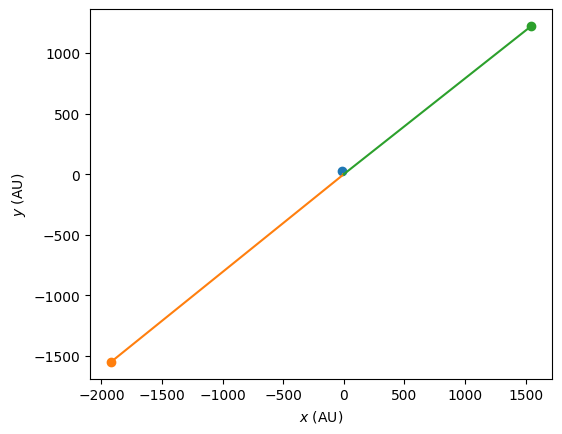

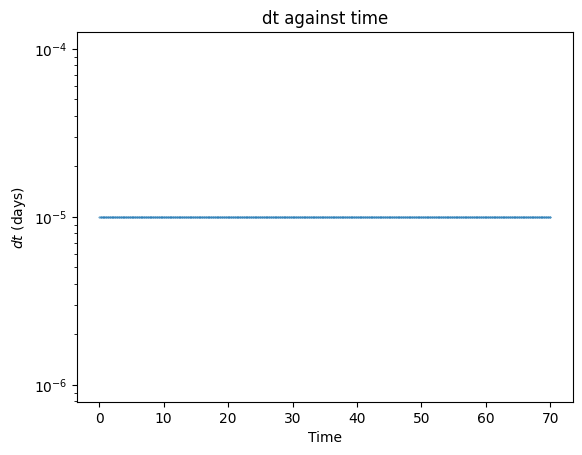

In [15]:
IAS15_system = grav_sim.create_system()
grav_sim.set_current_system(IAS15_system)
IAS15_system.load("pyth-3-body")

print("IAS15:")
grav_sim.launch_simulation(
    integrator="IAS15",
    tf=70.0,
    tolerance=1e-9,
)

grav_sim.plot_2d_trajectory()
grav_sim.plot_dt()

print("RK4:")
grav_sim.launch_simulation(
    integrator="rk4",
    tf=70.0,
    dt=1e-5,
    store_every_n=10000,
)

grav_sim.plot_2d_trajectory()
grav_sim.plot_dt()

### WHFast

When using WHFast, the order of adding objects matters. Since WHFast use Jacobi coordinate, we must first add the inner object. 

For convenience, you may also add the objects in any order, and then call `system.sort_by_distance(primary_object_name)` or `system.sort_by_distance(primary_object_index)`

In [16]:
WHFast_system = grav_sim.create_system()
grav_sim.set_current_system(WHFast_system)
WHFast_system.load("solar_system")

# Shuffle the system for demonstration
indices = np.arange(WHFast_system.objects_count, dtype=int)
np.random.shuffle(indices)
WHFast_system.x = WHFast_system.x[indices]
WHFast_system.v = WHFast_system.v[indices]
WHFast_system.m = WHFast_system.m[indices]
WHFast_system.objects_names = list(np.array(WHFast_system.objects_names)[indices])

print(f"Shuffled: {WHFast_system.objects_names}")

WHFast_system.sort_by_distance(primary_object_name="Sun")

print(f"Sorted: {WHFast_system.objects_names}")

Shuffled: ['Saturn', 'Uranus', 'Earth', 'Mars', 'Sun', 'Venus', 'Mercury', 'Jupiter', 'Neptune']
Sorted: ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']


Simulating the solar system with WHFast

Output()

Simulation information
Integration mode:  c_lib
System:  solar_system
Integrator:  WHFast
tf: 365242.189 days
dt: 1.095726567 days
tolerance:  None
store_every_n:  10
acceleration_method:  pairwise
storing_method:  default
flush_results_path:  None
no_progress_bar:  False
no_print:  False
softening_length:  0.0
Simulating the system...


Run time: 0.529 s



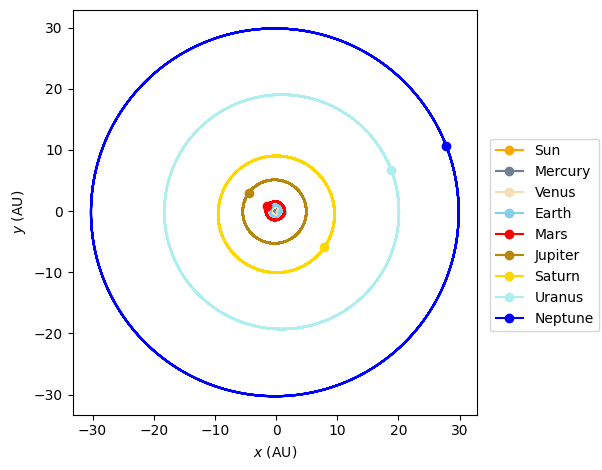

Output()

Computing energy...


Run time: 0.111 s



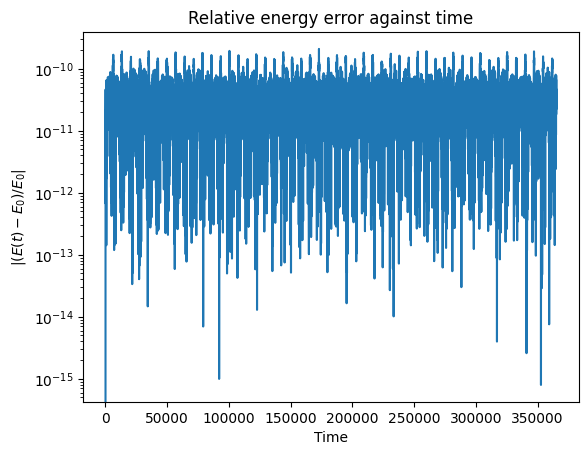

In [17]:
grav_sim.launch_simulation(
    integrator="WHFast",
    tf=grav_sim.years_to_days(1000.0),
    dt=grav_sim.years_to_days(0.003),
    store_every_n=10,
)

colors = [
    grav_sim.SOLAR_SYSTEM_COLORS[objects_name]
    for objects_name in system.objects_names[:-2]
]
colors.extend([None, None])

grav_sim.plot_2d_trajectory(
    colors=colors,
    legend=True,
    labels=WHFast_system.objects_names,
)
grav_sim.plot_rel_energy()

You may run the following code block to see what happens when we don't sort the order by distance. Usually, the system would become much more unstable and also have a larger energy error. Sometimes, the program may even get stuck.

Output()

['Uranus' 'Earth' 'Venus' 'Neptune' 'Jupiter' 'Mercury' 'Saturn' 'Sun'
 'Mars']
Simulation information
Integration mode:  c_lib
System:  solar_system
Integrator:  WHFast
tf: 109572.65669999999 days
dt: 1.095726567 days
tolerance:  None
store_every_n:  10
acceleration_method:  pairwise
storing_method:  default
flush_results_path:  None
no_progress_bar:  False
no_print:  False
softening_length:  0.0
Simulating the system...


Run time: 0.212 s



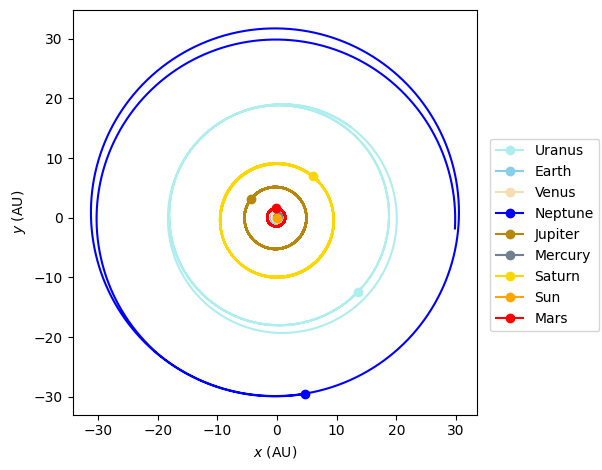

Output()

Computing energy...


Run time: 0.106 s



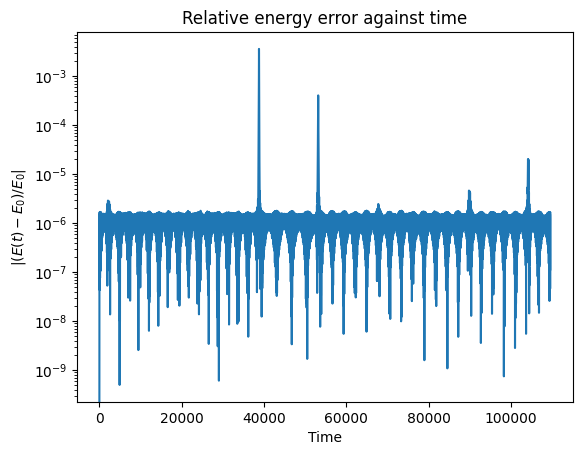

In [18]:
WHFast_system = grav_sim.create_system()
grav_sim.set_current_system(WHFast_system)
WHFast_system.load("solar_system")

# Shuffle the system for demonstration
indices = np.arange(WHFast_system.objects_count, dtype=int)
np.random.shuffle(indices)
WHFast_system.x = WHFast_system.x[indices]
WHFast_system.v = WHFast_system.v[indices]
WHFast_system.m = WHFast_system.m[indices]
WHFast_system.objects_names = np.array(WHFast_system.objects_names)[indices]

print(WHFast_system.objects_names)

grav_sim.launch_simulation(
    integrator="WHFast",
    tf=grav_sim.years_to_days(300.0),
    dt=grav_sim.years_to_days(0.003),
    store_every_n=10,
)

grav_sim.plot_2d_trajectory(
    colors=[
        grav_sim.SOLAR_SYSTEM_COLORS[objects_name]
        for objects_name in WHFast_system.objects_names
    ],
    legend=True,
    labels=WHFast_system.objects_names,
)
grav_sim.plot_rel_energy()

# END
Here is the end of the tutorial. Check out other projects in the `examples` folder for more advanced usage.
* `solar_system_one_mil_yrs.ipynb`
* `asteroid_belt_animation.py`
* `kirkwood_gap.py`